In [1]:
import matplotlib.pyplot as plt
from time import time
import torch
import importlib
from sklearn import datasets, manifold
import LMPL
from LMPL import LMPL_org,LMPL_F, train_org
import torch.optim as optim
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.datasets import make_swiss_roll

In [2]:
import numpy as np
from sklearn.manifold import trustworthiness
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
def calculate_metrics(high_dim_data, low_dim_data, n_neighbors=7):
    #Calculate evaluation metrics for dimensionality reduction.
    
    high_dim_dist = squareform(pdist(high_dim_data))
    low_dim_dist = squareform(pdist(low_dim_data))
    
    #Trustworthiness
    trustworthiness_score = trustworthiness(
        high_dim_data, 
        low_dim_data, 
        n_neighbors=n_neighbors
    )
    
    # Continuity
    continuity = trustworthiness(
        low_dim_data, 
        high_dim_data, 
        n_neighbors=n_neighbors
    )
    
    
    def calculate_raar(X_high, X_low, k=n_neighbors):
        n_samples = X_high.shape[0]
        
        # Find k-nearest neighbors in both spaces
        knn_high = NearestNeighbors(n_neighbors=k+1) 
        knn_low = NearestNeighbors(n_neighbors=k+1)
        
        knn_high.fit(X_high)
        knn_low.fit(X_low)
        
        # Get neighbor indices
        high_indices = knn_high.kneighbors(X_high, return_distance=False)[:, 1:]  # Remove self
        low_indices = knn_low.kneighbors(X_low, return_distance=False)[:, 1:]    # Remove self
        
        # Calculate agreement
        agreement_sum = 0
        for i in range(n_samples):
            high_neighbors = set(high_indices[i])
            low_neighbors = set(low_indices[i])
            agreement = len(high_neighbors.intersection(low_neighbors))
            agreement_sum += agreement / k
            
        Q_knn = agreement_sum / n_samples
    
        F_knn = ((n_samples-1) * Q_knn - k) / (n_samples-1 - k)
        
        return F_knn
    
    raar_score = calculate_raar(high_dim_data, low_dim_data, k=n_neighbors)
    
    print(f'{trustworthiness_score:.08f}',' & ',f'{continuity:.08f}',' & ',f'{raar_score:08f}')
    return {
        'trustworthiness': trustworthiness_score,
        'continuity': continuity,
        'raar_score':raar_score
    }


In [3]:
def train_model_F(alpha,X,input_dim=3,output_dim=2,epochs=400,learning_rate=0.005,hidden_layers=[10,20]):
    model=LMPL_F(input_dim, output_dim, alpha, hidden_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    t0=time()
    y_train = train_org(model, optimizer, X, epochs, alpha)
    t1=time()
    t=t1-t0
    return y_train,t

def train_model(alpha,epsilon, X, input_dim=3, output_dim=2, epochs=400, learning_rate=0.005, hidden_layers=[10,20]):
    model = LMPL_org(input_dim, output_dim, alpha, epsilon=epsilon,hidden_layers=hidden_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    t0=time()
    y_train = train_org(model, optimizer, X, epochs, alpha)
    t1=time()
    t=t1-t0
    return y_train,t

def plot_results(y_train, title,xmin,xmax,ymin,ymax):
    if isinstance(y_train, torch.Tensor):
        y_train_np = y_train.detach().numpy()
    else:
        y_train_np = y_train
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(y_train_np[:, 0], y_train_np[:, 1], c=y, s=50, alpha=0.8)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    plt.title(title)
    plt.show()

def lmpl_g_train(distance,epsilon_over_dis,x_train,lr,epochs,hidden_layers):
    epsilon=distance*epsilon_over_dis
    alpha=1/(distance+epsilon)
    y_train,t= train_model(alpha, epsilon,x_train, learning_rate=lr, epochs=epochs, hidden_layers=hidden_layers) 
    #plot_results(y_train,'LMPL')
    print("LMPL_g: %.2g sec" % (t))
    return y_train
    
def lmpl_f_train(alpha,X,lr,epochs,hidden_layers):
    y_train,t= train_model_F(alpha, X, learning_rate=lr, epochs=epochs, hidden_layers=hidden_layers) 
    plot_results(y_train,'LMPL_f')
    print("LMPL_f: %.2g sec" % (t))
    return y_train
    


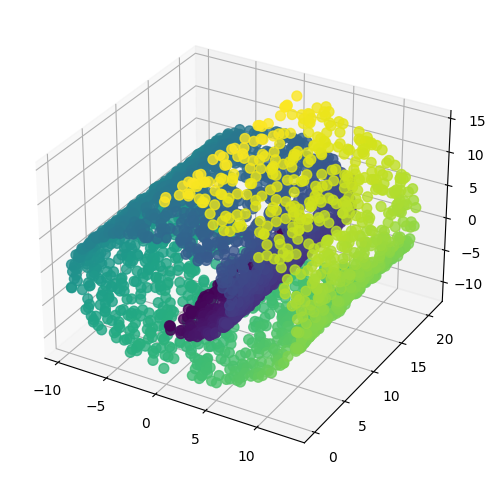

In [4]:
X, y = make_swiss_roll(n_samples=3000,noise=0.1)

x_train = torch.from_numpy(X).float()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, alpha=0.8)
plt.show()

LLE: 0.19 sec


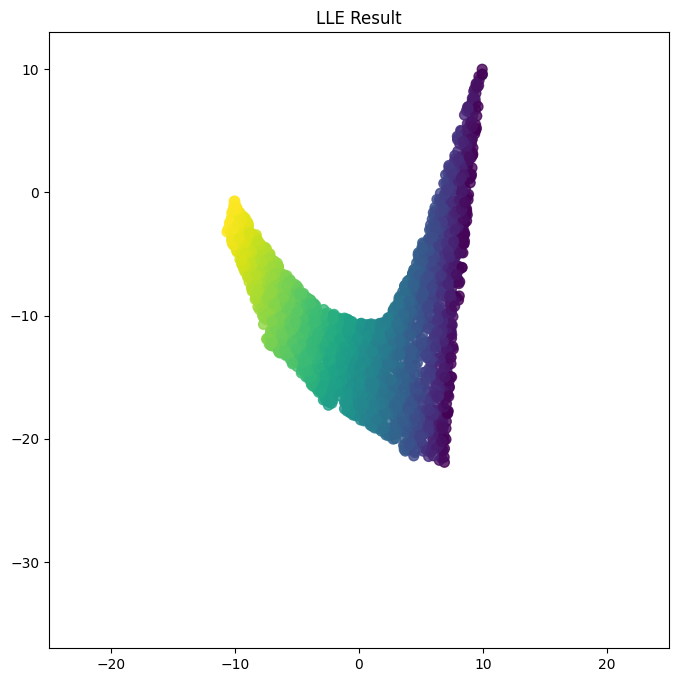

0.99873965  &  0.99884422  &  0.667128
{'trustworthiness': 0.9987396485526295, 'continuity': 0.9988442224665042, 'raar_score': 0.6671278011204598}


In [5]:
###LLE
x_min, x_max = -25, 25
y_min, y_max = -37, 13
t0=time()
lle=manifold.LocallyLinearEmbedding(n_neighbors=10,n_components=2).fit_transform(X)
t1 = time()
print("LLE: %.2g sec" % (t1 - t0))
target_scale = -20  
embedding_scaled = lle * target_scale / np.max(np.abs(lle))

#scale result
y_center_desired = -10 
y_shift = y_center_desired - embedding_scaled[:,1].mean()
embedding_scaled[:,1] += y_shift 
plot_results(embedding_scaled,'LLE Result',x_min,x_max,y_min,y_max)
print(calculate_metrics(X,lle,7))

/home3/wangkeyu3/Desktop/LMPL/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS: 11 sec


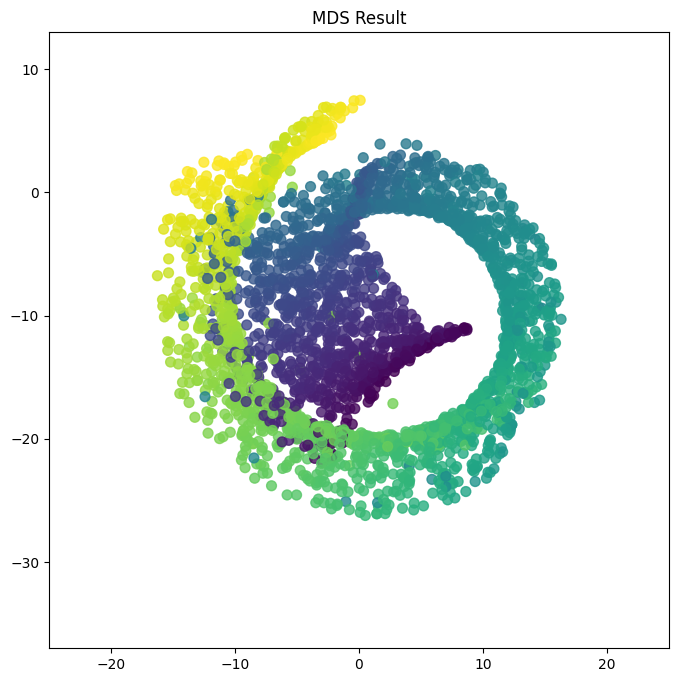

0.92829094  &  0.98906406  &  0.504415
{'trustworthiness': 0.9282909397951218, 'continuity': 0.9890640602845353, 'raar_score': 0.5044146772345312}


In [26]:
###MDS
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1).fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
#scale
y_center_desired = -10  
y_shift = y_center_desired - mds[:,1].mean()
mds[:,1] += y_shift  
plot_results(mds,'MDS Result',x_min,x_max,y_min,y_max)
print(calculate_metrics(X,mds,7))

ISO-map: 2.8 sec


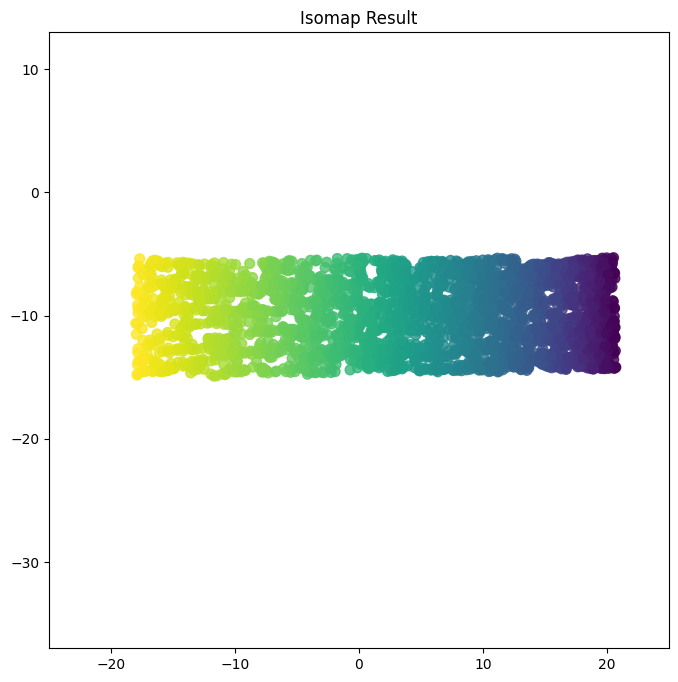

TypeError: plot_results() missing 4 required positional arguments: 'xmin', 'xmax', 'ymin', and 'ymax'

In [7]:
t0 = time()
iso = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(X)
t1 = time()
print("ISO-map: %.2g sec" % (t1 - t0))
target_scale = -23  
embedding_scaled = iso * target_scale / np.max(np.abs(iso))
y_center_desired = -10  
y_shift = y_center_desired - embedding_scaled[:,1].mean()
embedding_scaled[:,1] += y_shift  
x_center_desired = 5  
x_shift = x_center_desired - embedding_scaled[:, 0].mean()
embedding_scaled[:, 0] += x_shift 
plot_results(embedding_scaled,'Isomap Result',x_min,x_max,y_min,y_max)

plot_results(iso,'Iso Result')
#print(calculate_metrics(X,iso,7))

Epoch [1/600], Loss: 0.0267
Epoch [100/600], Loss: 0.0027
Epoch [200/600], Loss: 0.0026
Epoch [300/600], Loss: 0.0022
Epoch [400/600], Loss: 0.0020
Epoch [500/600], Loss: 0.0014
Epoch [600/600], Loss: 0.0012


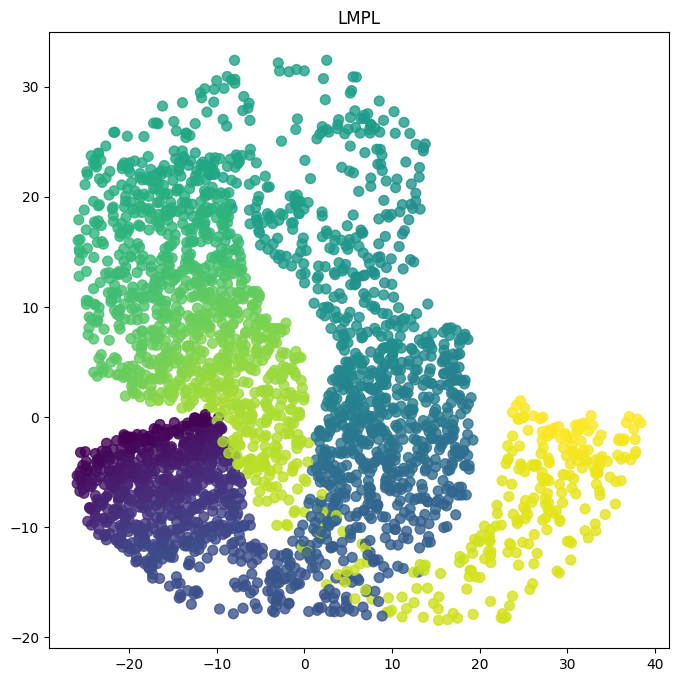

LMPL_g: 58 sec


In [8]:
dis=4
hiddenlayers=[64,32]
epsilons=0.1
lr=0.05
lmpl_g=lmpl_g_train(dis,epsilons,x_train,lr,epochs=600,hidden_layers=hiddenlayers)

In [9]:
lmpl_g=lmpl_g.detach().numpy()
print(calculate_metrics(X,lmpl_g,7))

{'trustworthiness': 0.980688524590164, 'continuity': 0.9976002166674632, 'raar_score': 0.6492288801884515}


Epoch [1/600], Loss: 0.0048
Epoch [100/600], Loss: 0.0020
Epoch [200/600], Loss: 0.0010
Epoch [300/600], Loss: 0.0009
Epoch [400/600], Loss: 0.0009
Epoch [500/600], Loss: 0.0009
Epoch [600/600], Loss: 0.0009


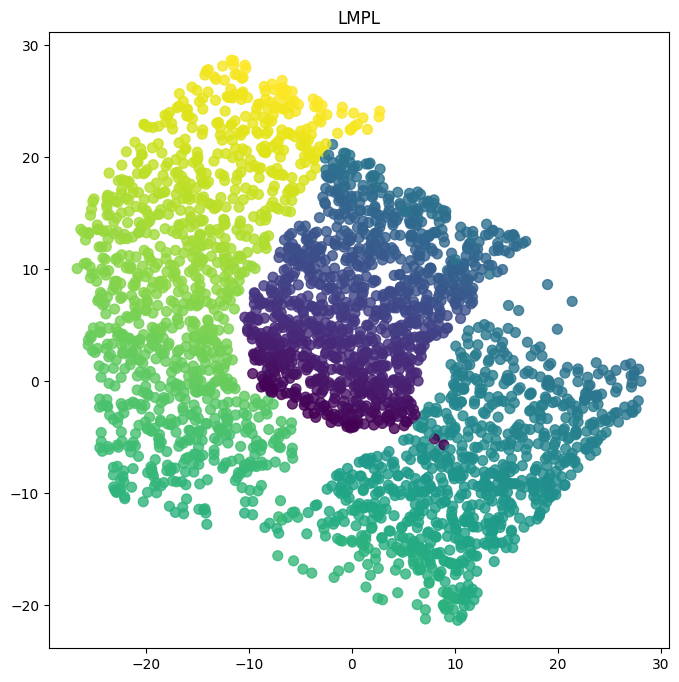

LMPL_g: 54 sec


In [10]:
dis=4
hiddenlayers=[64,32]
epsilons=0.1
lr=0.05
lmpl_g=lmpl_g_train(dis,epsilons,x_train,lr,epochs=600,hidden_layers=hiddenlayers)

In [11]:
lmpl_g=lmpl_g.detach().numpy()
print(calculate_metrics(X,lmpl_g,7))

{'trustworthiness': 0.9949943602733834, 'continuity': 0.9975070974525642, 'raar_score': 0.7414918512859817}


Epoch [1/600], Loss: 0.0047
Epoch [100/600], Loss: 0.0031
Epoch [200/600], Loss: 0.0028
Epoch [300/600], Loss: 0.0028
Epoch [400/600], Loss: 0.0028
Epoch [500/600], Loss: 0.0010
Epoch [600/600], Loss: 0.0009


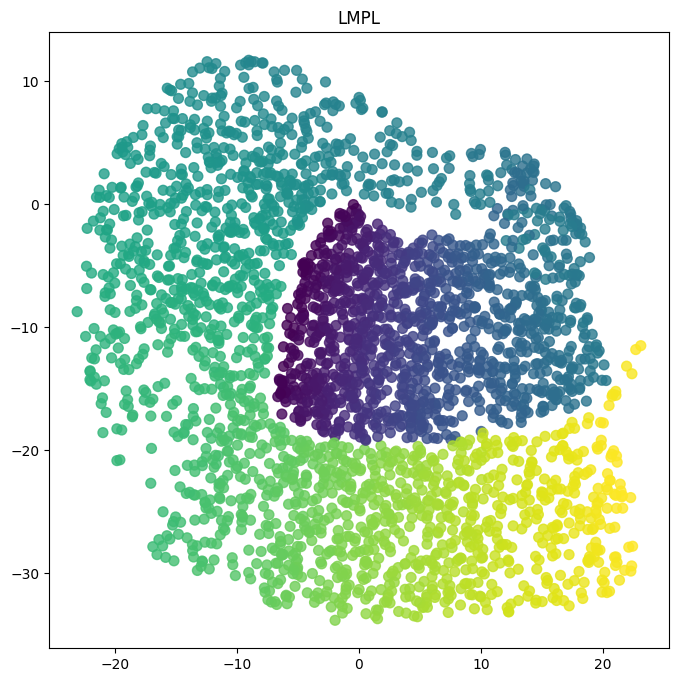

LMPL_g: 68 sec


In [13]:
dis=4
hiddenlayers=[256,128]
epsilons=0.1
lr=0.02
lmpl_g=lmpl_g_train(dis,epsilons,x_train,lr,epochs=600,hidden_layers=hiddenlayers)

In [14]:
lmpl_g=lmpl_g.detach().numpy()
print(calculate_metrics(X,lmpl_g,7))

{'trustworthiness': 0.9919162484665998, 'continuity': 0.9985357580971499, 'raar_score': 0.732279873312973}


Epoch [1/500], Loss: 0.0347
Epoch [100/500], Loss: 0.0044
Epoch [200/500], Loss: 0.0042
Epoch [300/500], Loss: 0.0032
Epoch [400/500], Loss: 0.0015
Epoch [500/500], Loss: 0.0012


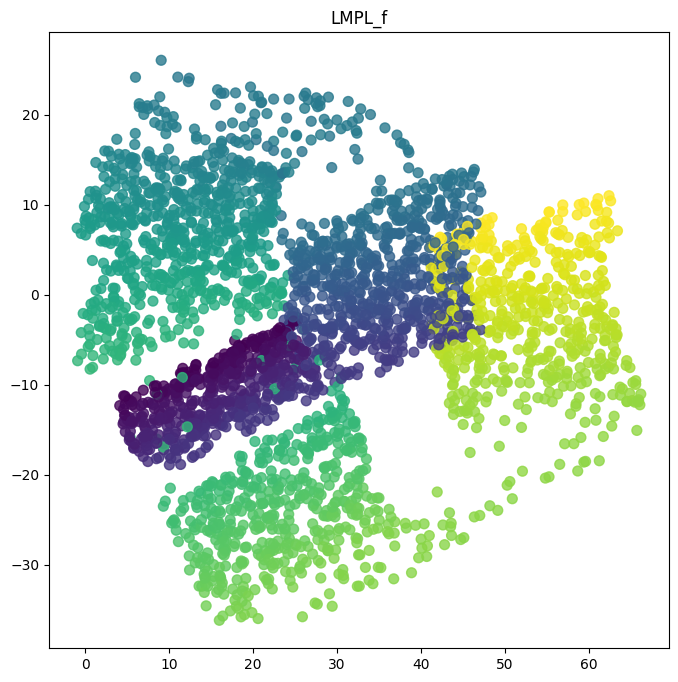

LMPL_f: 49 sec


In [8]:
alpha=2
hiddenlayers=[64,32]
lr=0.05
lmpl_f_train(alpha,x_train,lr,epochs=500,hidden_layers=hiddenlayers)

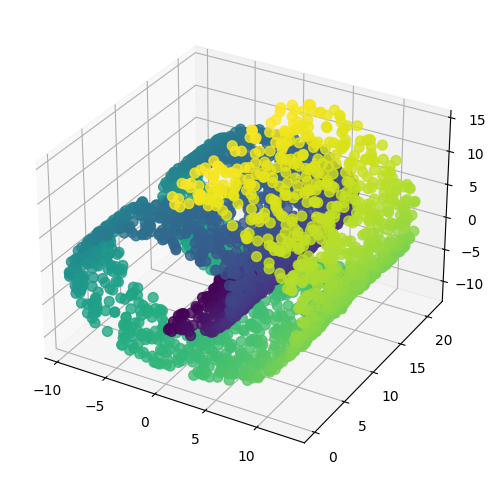

In [8]:
X_h, y = make_swiss_roll(n_samples=3000,hole=True,noise=0.1)

x_train_h = torch.from_numpy(X_h).float()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_h[:, 0], X_h[:, 1], X_h[:, 2], c=y, s=50, alpha=0.8)

LLE: 0.2 sec


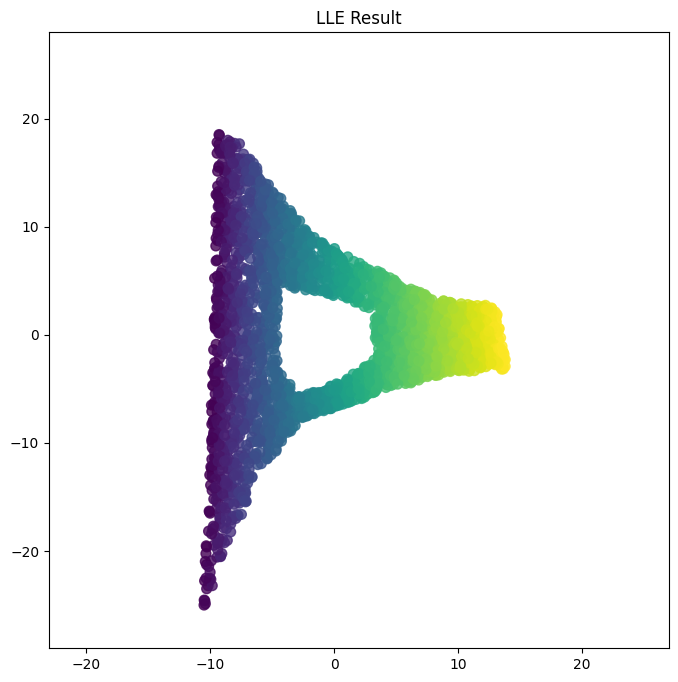

0.99881883  &  0.99887677  &  0.695671
{'trustworthiness': 0.9988188277652982, 'continuity': 0.9988767703802832, 'raar_score': 0.6956706137000327}


In [9]:
###LLE
x_min, x_max = -23, 27
y_min, y_max = -29, 28

t0=time()
lle_h=manifold.LocallyLinearEmbedding(n_neighbors=10,n_components=2).fit_transform(X_h)
t1 = time()
print("LLE: %.2g sec" % (t1 - t0))
target_scale = -25  # 例如缩放到 [-10, 10]
embedding_scaled = lle_h * target_scale / np.max(np.abs(lle_h))

y_center_desired = -0  # 希望 x 的中心在 0
y_shift = y_center_desired - embedding_scaled[:,1].mean()
embedding_scaled[:,1] += y_shift  # 平移 x 轴的数据
plot_results(embedding_scaled,'LLE Result',x_min,x_max,y_min,y_max)
print(calculate_metrics(X_h,lle_h,7))
###MDS

/home3/wangkeyu3/Desktop/LMPL/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS: 11 sec


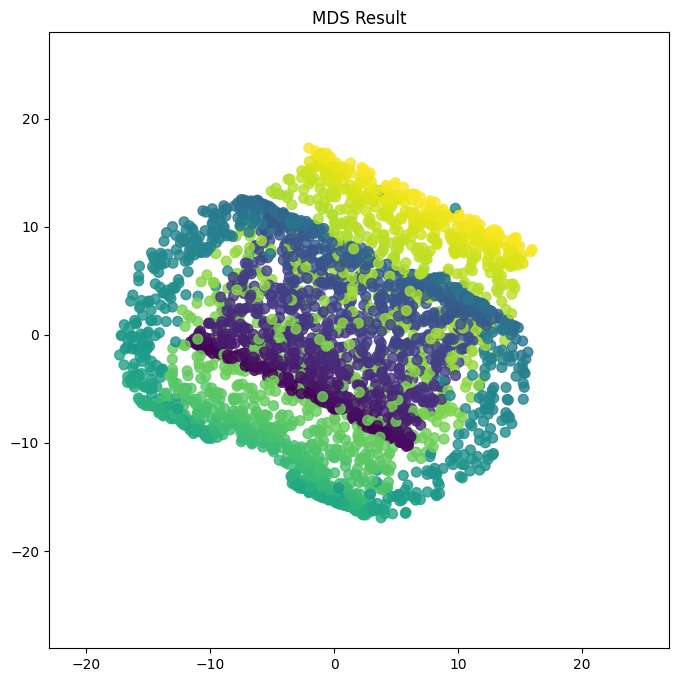

0.95544342  &  0.99030016  &  0.582311
{'trustworthiness': 0.9554434195223757, 'continuity': 0.9903001640937406, 'raar_score': 0.5823107811306406}


In [47]:
t0 = time()
mds_h = manifold.MDS(2, max_iter=100, n_init=1).fit_transform(X_h)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
y_center_desired = -0  
y_shift = y_center_desired - mds_h[:,1].mean()
mds[:,1] += y_shift  
plot_results(mds_h,'MDS Result',x_min,x_max,y_min,y_max)
#plot_results(mds_h,'MDS Result')
print(calculate_metrics(X_h,mds_h,7))

ISO: 2.8 sec


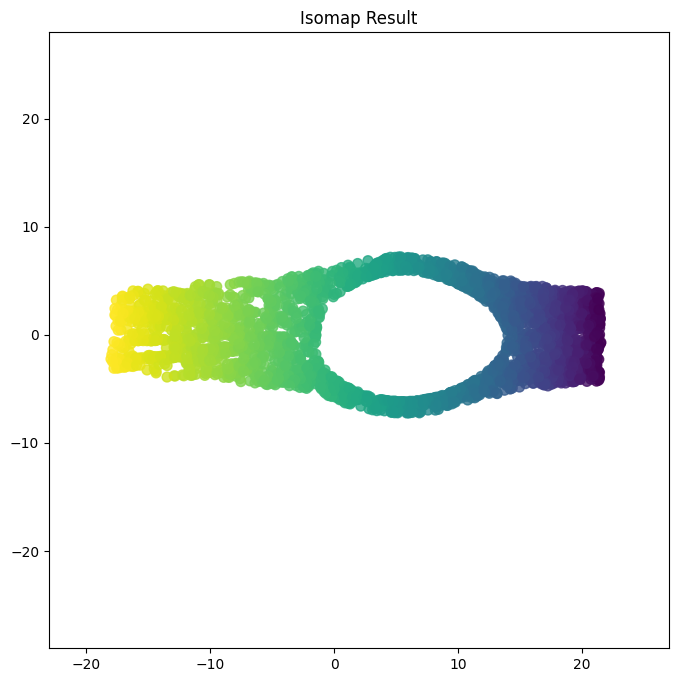

TypeError: plot_results() missing 4 required positional arguments: 'xmin', 'xmax', 'ymin', and 'ymax'

In [10]:
###ISO-map
t0 = time()
iso_h = manifold.Isomap(n_neighbors=10, n_components=2)\
    .fit_transform(X_h)
t1 = time()
print("%s: %.2g sec" % ('ISO', t1 - t0))
target_scale = -23  
embedding_scaled = iso_h * target_scale / np.max(np.abs(iso_h))
y_center_desired = 0  
y_shift = y_center_desired - embedding_scaled[:,1].mean()
embedding_scaled[:,1] += y_shift  
x_center_desired = 5  
x_shift = x_center_desired - embedding_scaled[:, 0].mean()
embedding_scaled[:, 0] += x_shift 
plot_results(embedding_scaled,'Isomap Result',x_min,x_max,y_min,y_max)

plot_results(iso_h,'ISOmap Result')
print(calculate_metrics(X_h,iso_h,7))

In [52]:
dis=4
hiddenlayers=[64,32]
epsilons=0.1
lr=0.05
lmpl_h=lmpl_g_train(dis,epsilons,x_train_h,lr,epochs=600,hidden_layers=hiddenlayers)

Epoch [1/600], Loss: 0.0058
Epoch [100/600], Loss: 0.0023
Epoch [200/600], Loss: 0.0010
Epoch [300/600], Loss: 0.0009
Epoch [400/600], Loss: 0.0009
Epoch [500/600], Loss: 0.0009
Epoch [600/600], Loss: 0.0009
LMPL_g: 53 sec


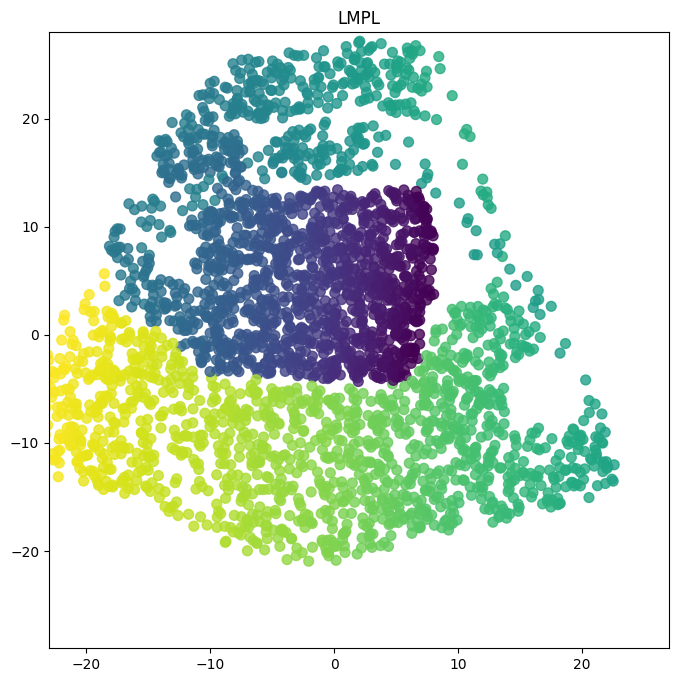

0.99283291  &  0.99862951  &  0.757386
{'trustworthiness': 0.9928329111504086, 'continuity': 0.9986295145692937, 'raar_score': 0.7573860930736033}


In [53]:
lmpl_h=lmpl_h.detach().numpy()
plot_results(lmpl_h,'LMPL',x_min,x_max,y_min,y_max)
print(calculate_metrics(X_h,lmpl_h,7))

In [9]:
dis=4
hiddenlayers=[64,32]
epsilons=0.1
lr=0.05
lmpl_h=lmpl_g_train(dis,epsilons,x_train_h,lr,epochs=600,hidden_layers=hiddenlayers)

{'trustworthiness': 0.9909582596504644, 'continuity': 0.9978901209195622, 'raar_score': 0.7242134262796172}


Epoch [1/600], Loss: 0.0160
Epoch [100/600], Loss: 0.0027
Epoch [200/600], Loss: 0.0027
Epoch [300/600], Loss: 0.0016
Epoch [400/600], Loss: 0.0010
Epoch [500/600], Loss: 0.0009
Epoch [600/600], Loss: 0.0009


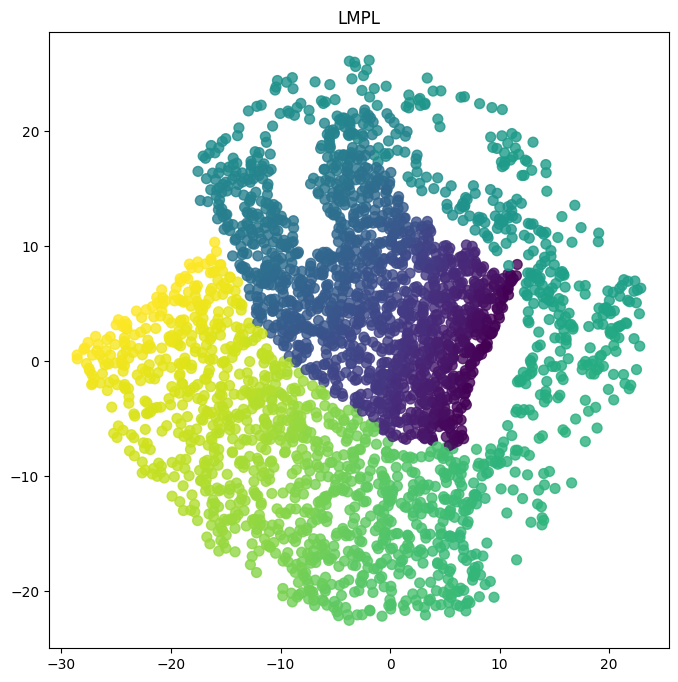

LMPL_g: 58 sec


In [10]:
lmpl_h=lmpl_h.detach().numpy()
print(calculate_metrics(X,lmpl_h,7))

In [13]:

alpha=4
hiddenlayers=[128,64]
lr=0.05
lmpl_f_train(alpha,x_train_h,lr,epochs=500,hidden_layers=hiddenlayers)

{'trustworthiness': 0.9938653156813076, 'continuity': 0.9992303525625706, 'raar_score': 0.7289864718614854}


Epoch [1/500], Loss: 0.4261
Epoch [100/500], Loss: 0.0271
Epoch [200/500], Loss: 0.0185
Epoch [300/500], Loss: 0.0159
Epoch [400/500], Loss: 0.0147
Epoch [500/500], Loss: 0.0137


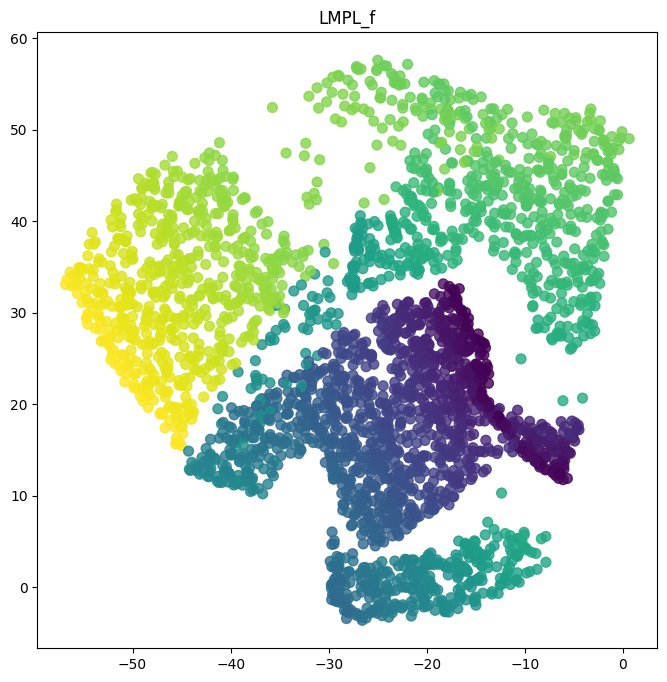

LMPL_f: 37 sec


tensor([[-10.1440,  15.0535],
        [-31.9667,  22.9351],
        [-10.0644,  42.6190],
        ...,
        [ -2.9862,  47.3919],
        [-12.8163,  51.2832],
        [-35.9731,  16.6883]], grad_fn=<AddBackward0>)